In [30]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as msno
pd.set_option('max_columns' , 100)
plt.style.use("seaborn-dark")
 

In [31]:
df = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2022_per_game.html')

In [32]:
df = df[0]

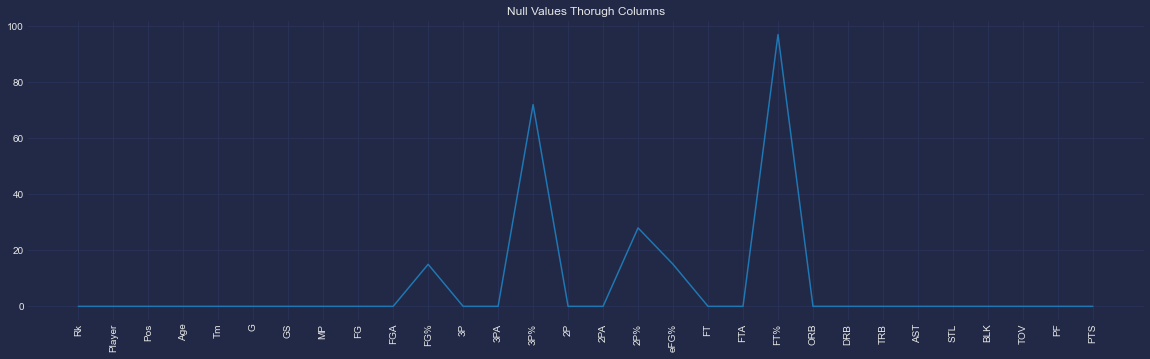

In [34]:
plt.plot(df.isna().sum()) 
# refrenced by https://matplotlib.org/matplotblog/posts/matplotlib-cyberpunk-style/ 
for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey
plt.rcParams['figure.figsize'] = (20 , 5.5 )  
plt.xticks(rotation = 90)
plt.grid(color='#2A3459')
plt.title('Null Values Thorugh Columns')
plt.show()

# Missing values

In [48]:
# changing dtype str to float 
# refrenced by -> https://stackoverflow.com/questions/46893921/converting-strings-to-floats-valueerror-could-not-convert-string-to-float
# for numerical columns change there dtype in for lopp 
# float 
for col in ['PTS' , 
            'MP' ,
            'FG' , 
            'FGA',
            'FG%' ,
            '3P' ,
            '3PA',
            '3P%' ,
            '2P',
            '2PA' ,
            '2P%',
            'eFG%',
            'FT',
            'AST',
            'FTA',
            'FT%',
            'ORB' ,
            'DRB' , 
            'TRB' , 
            'STL' , 
            'BLK' , 
            'TOV' ,
            'PF' ]:
    df[col] = df[col].apply(pd.to_numeric,errors='coerce')
    df[col] = df[col].replace(np.nan , 0 ) 
    df[col] = df[col].astype('float16')
# int 
for col in ['Age' , 'G' , 'GS']:
     df[col] = df[col].apply(pd.to_numeric,errors='coerce')
     df[col] = df[col].replace(np.nan , 0 ) 
     df[col] = df[col].astype('int16')
     

# EDA 

- numerical values  -> into discrete values also - continuous values 
- categorical values -> numerical categorical - categorical as objects 

In [49]:
discreate_numerical_features = [n for n in df.columns if len(df[n].unique()) <= 25 and df[n].dtype != 'O']
discreate_numerical_features

['Age', 'STL', 'BLK']

<AxesSubplot:>

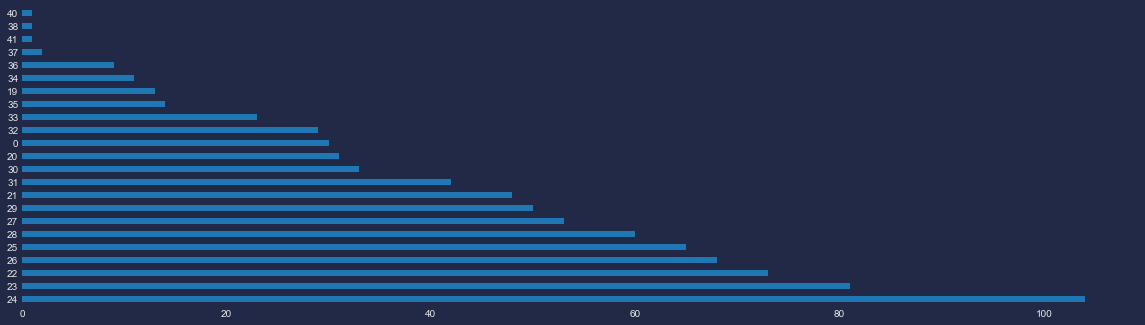

In [50]:
# ploting age distribution 
(df['Age']
.value_counts()
.plot(kind = 'barh') 
)

<AxesSubplot:>

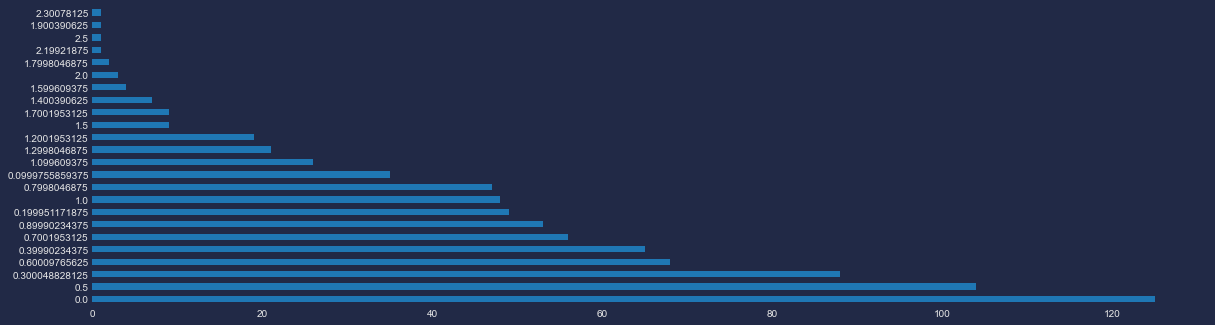

In [51]:
(df['STL']
 .value_counts()
 .plot(kind = 'barh')
)

<AxesSubplot:>

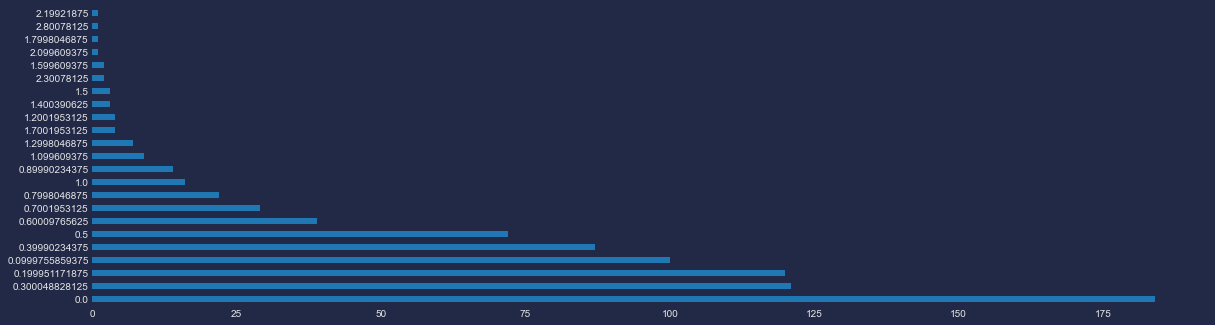

In [52]:
(df['BLK']
 .value_counts()
 .plot(kind = 'barh')
)

In [53]:
continus_numerical_features = [c for c in df.columns  if df[c].dtype != 'O' and c not in discreate_numerical_features] 
continus_numerical_features

['G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'TOV',
 'PF',
 'PTS']

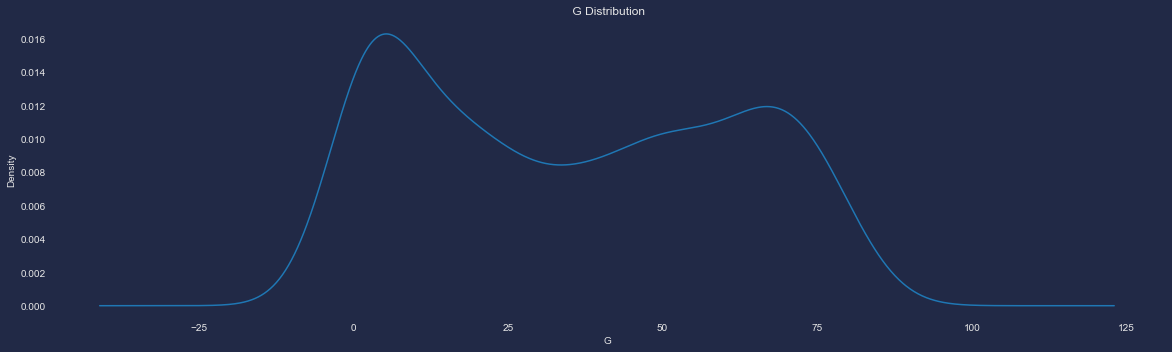

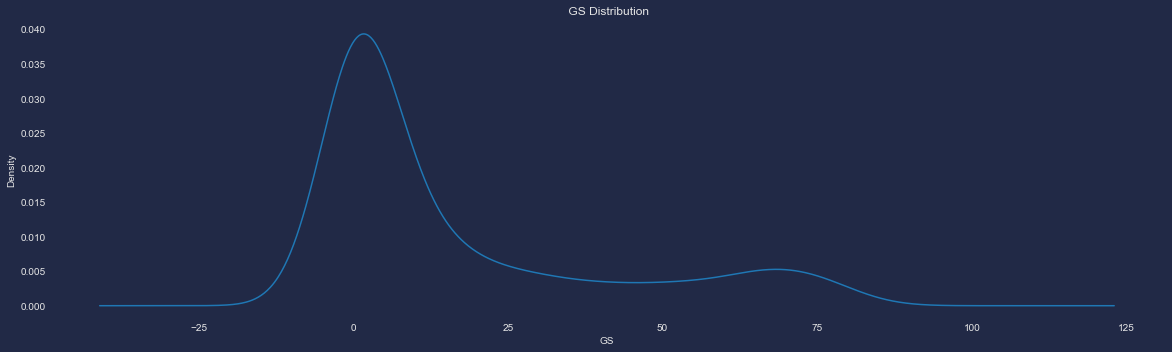

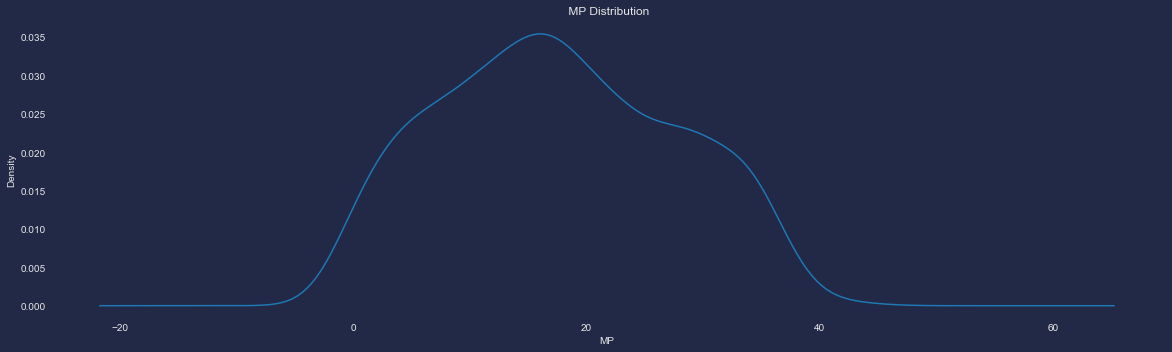

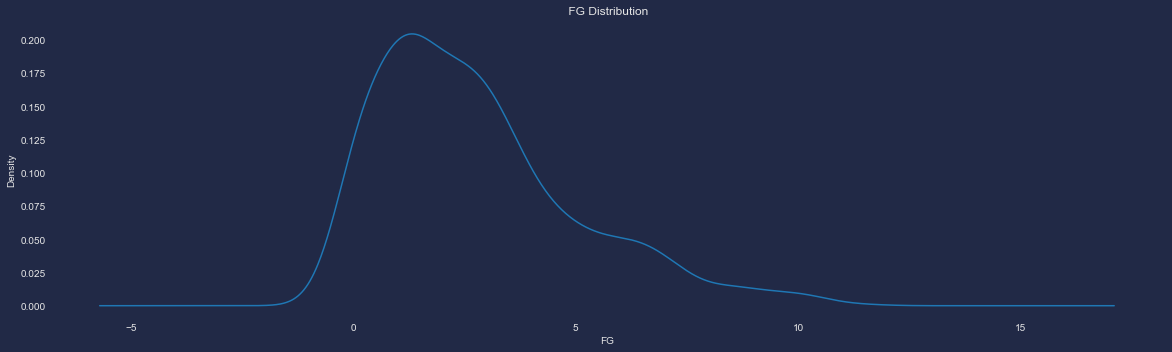

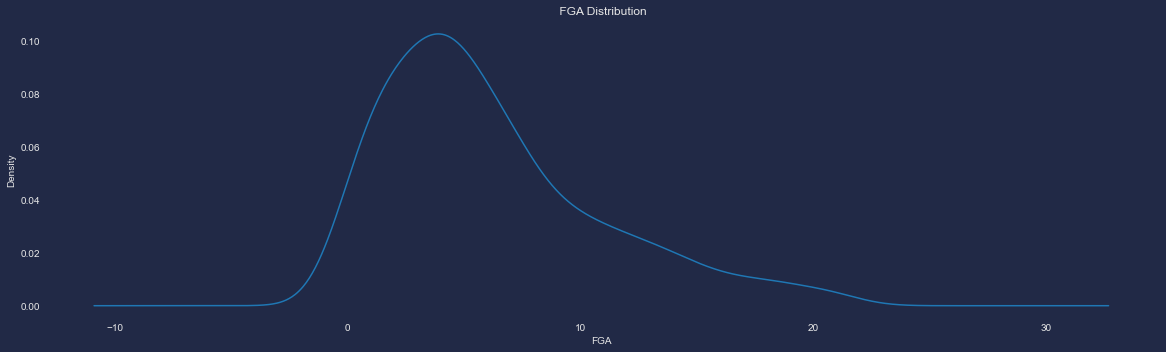

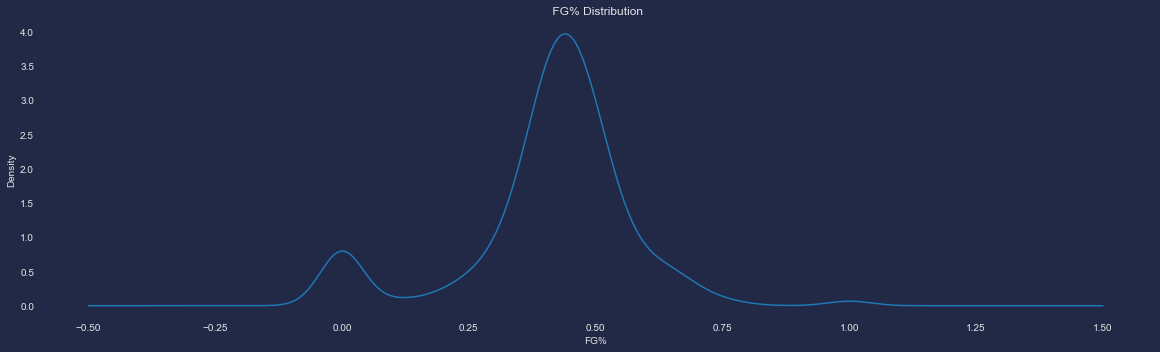

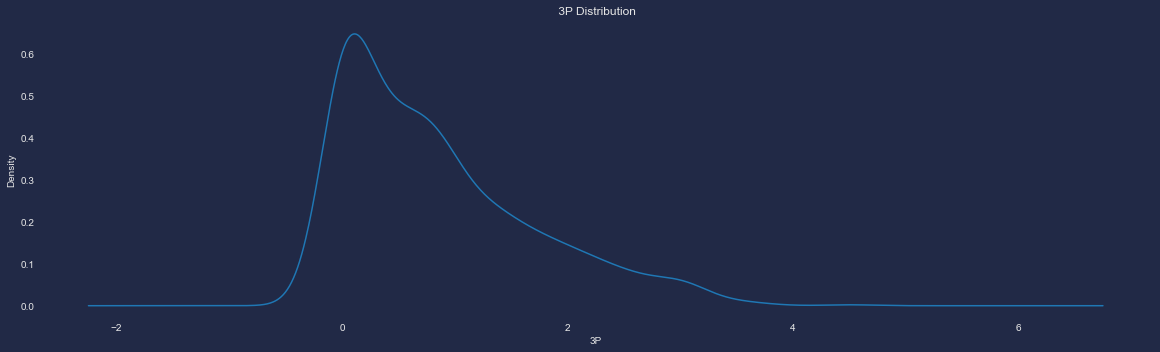

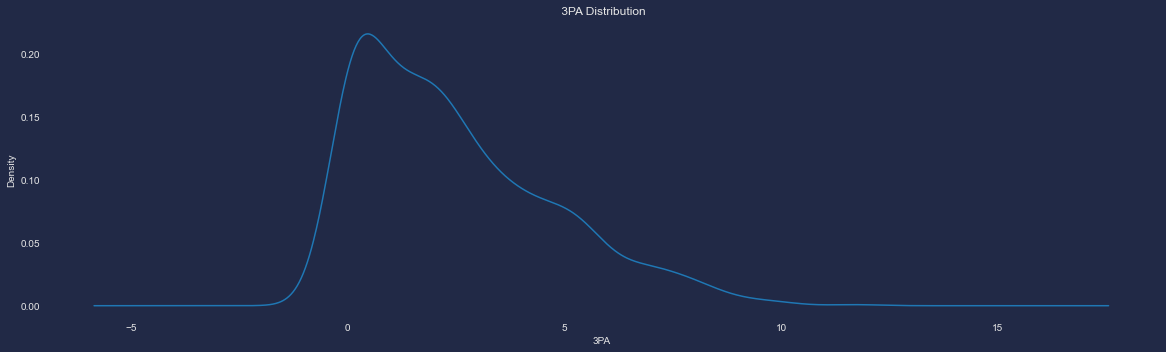

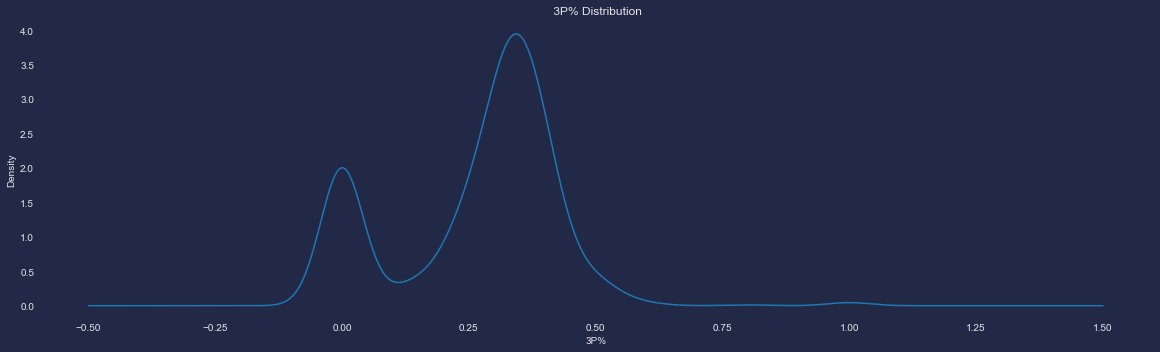

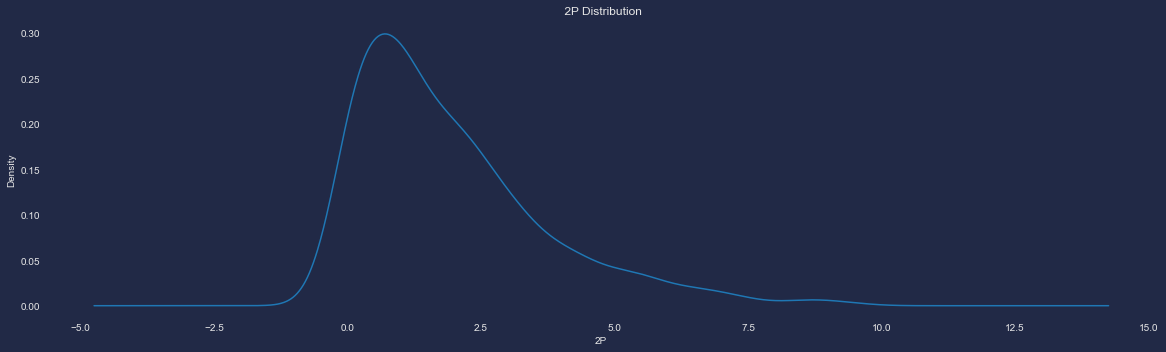

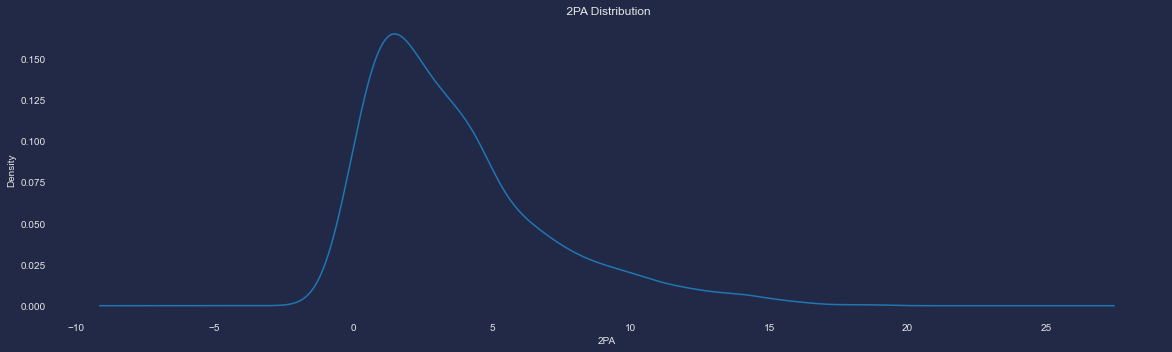

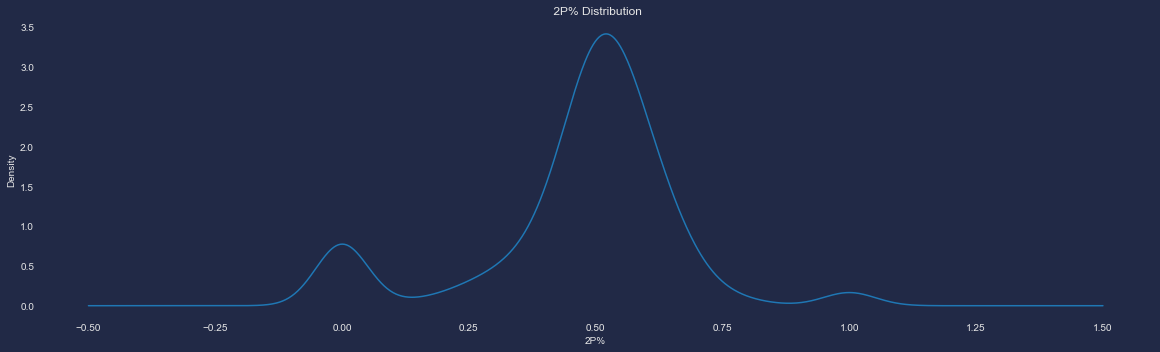

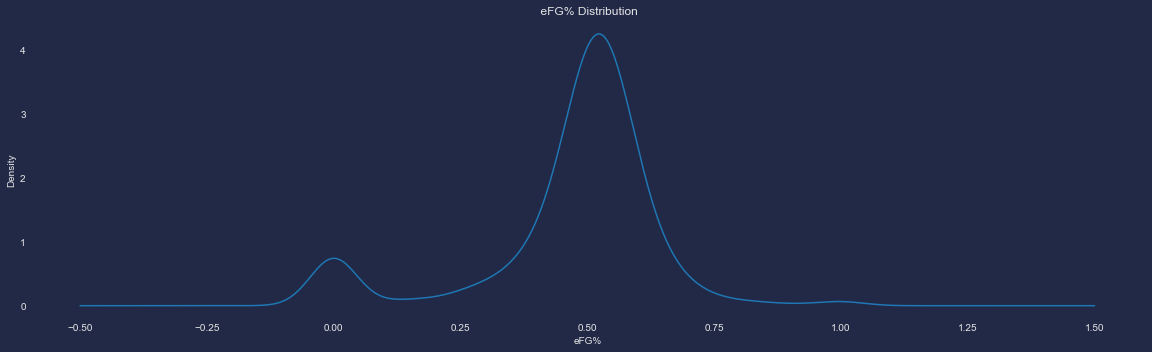

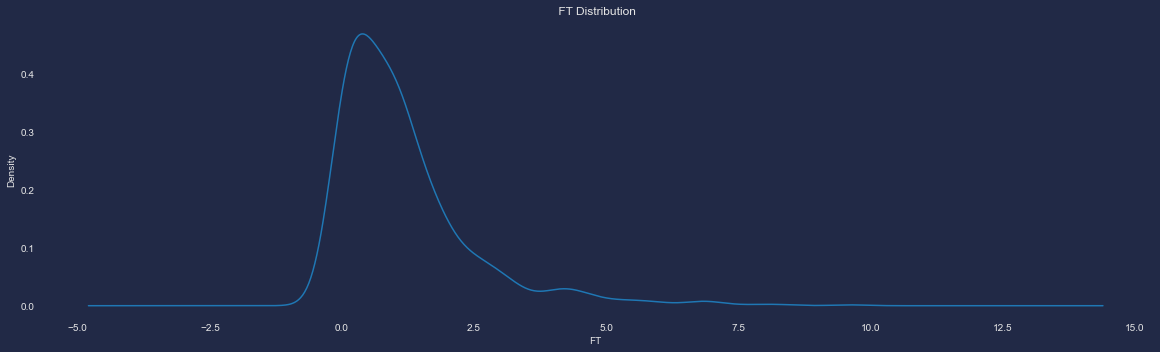

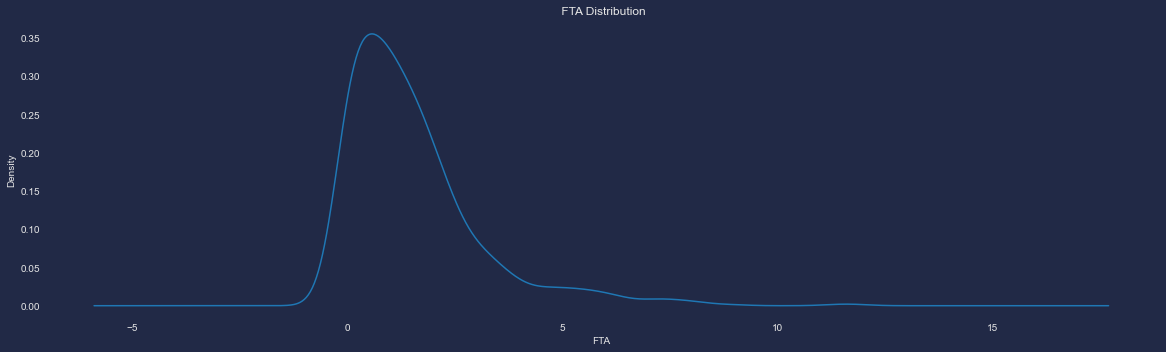

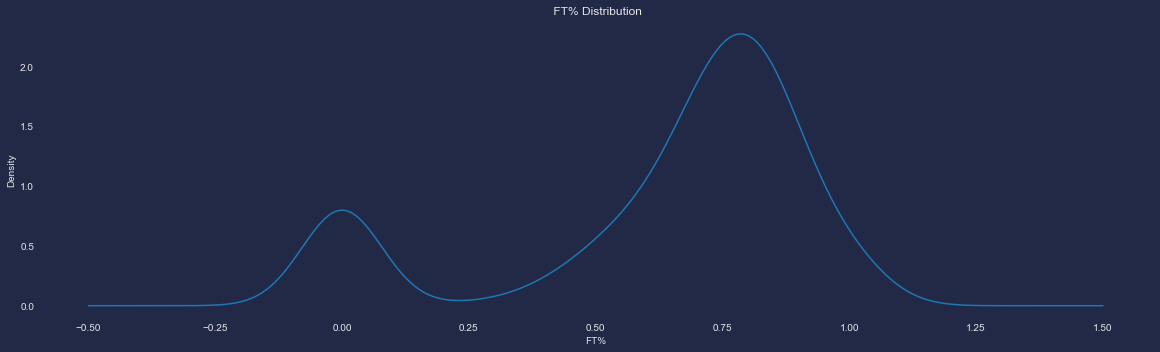

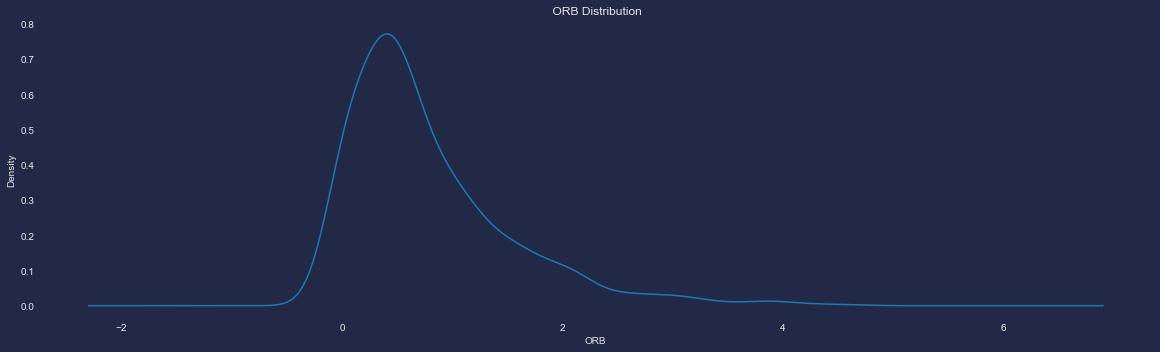

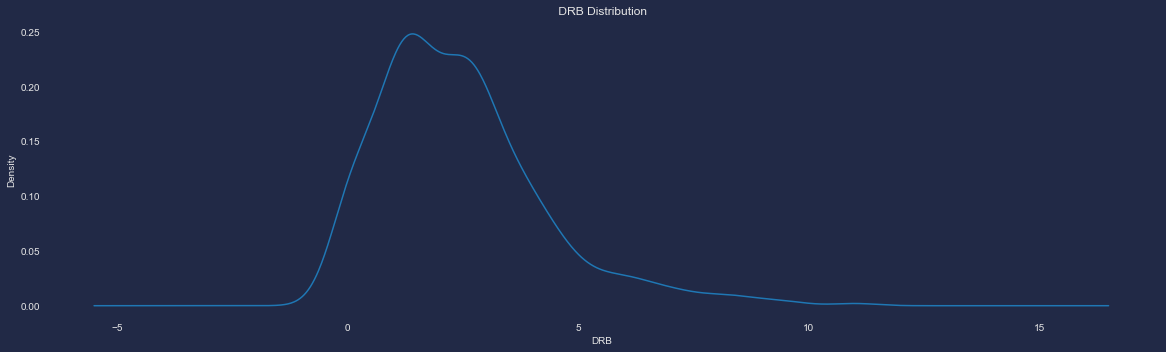

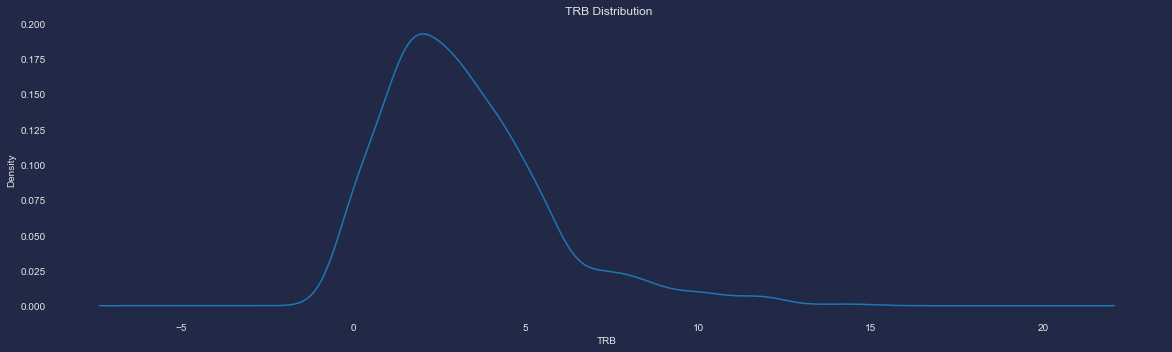

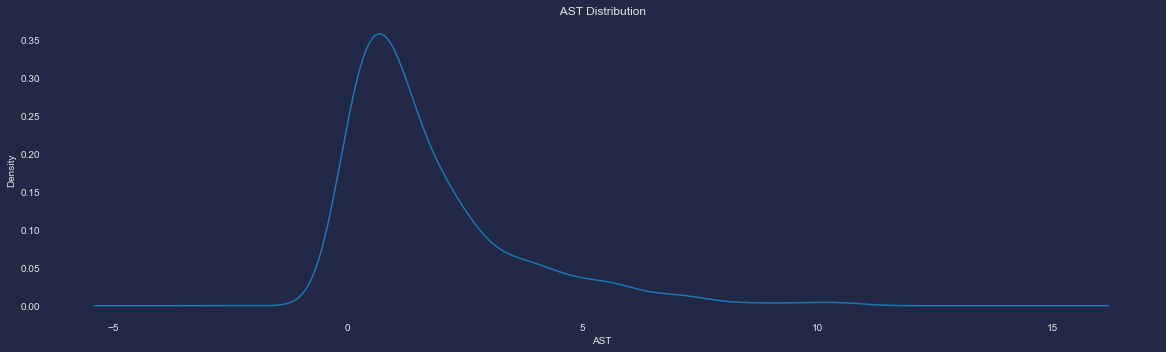

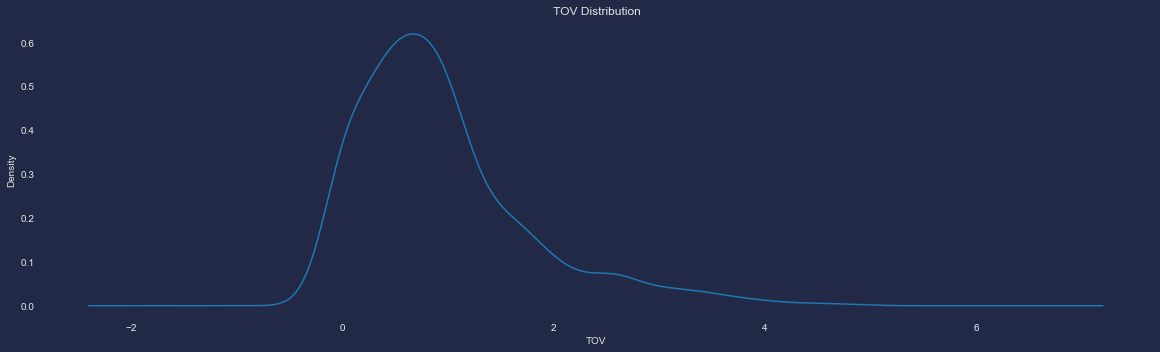

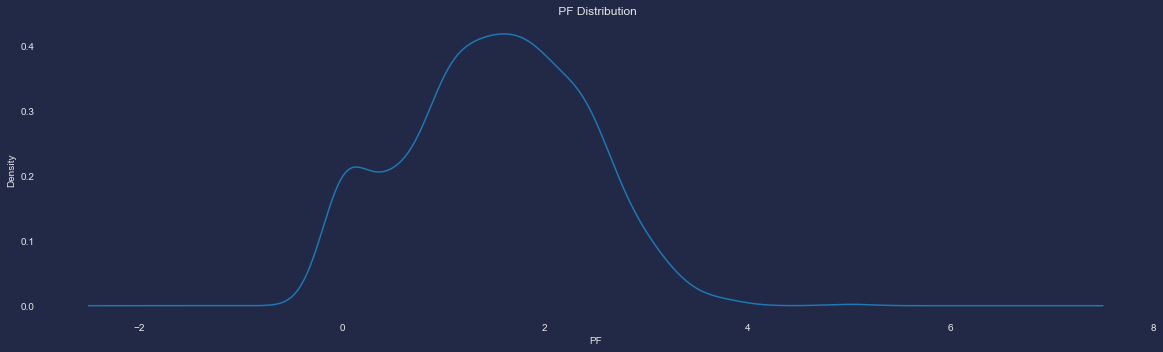

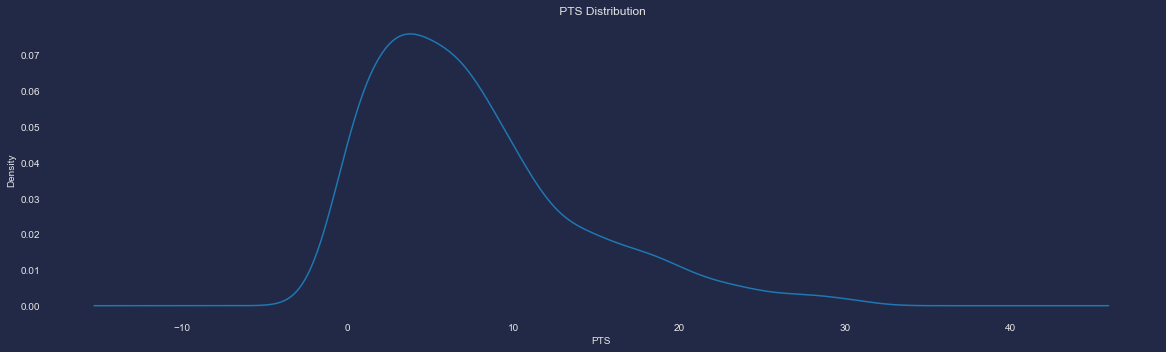

In [54]:
from scipy.stats import norm  
for c in continus_numerical_features : 
    (df[c]

     .plot.kde()
     



    )
    plt.xlabel(c)
    plt.title(f' {c} Distribution')
    plt.show()
     

### some distributions sames lime they skwed for modeling purposes have to tranform skwed columns but now i'll leave them alone

# Aggregations 

- some insight answring some questions 

In [43]:
# TOP 5 players by PTS
top_5 = (df.groupby(['Player' ,  'Pos' , 'Tm'])['PTS']
 .max()
 .reset_index()
 .sort_values(by = ['PTS'] , ascending = False)[:5]
#  .plot(kind = 'hist')
 
)
# plt.show()

In [25]:
import plotly.express as px 
fig = px.bar(top_5  , x =  'Player' , y = 'PTS'  , color = 'Tm'  , text='Pos' , title = 'TOP 5 Player By PTS ')
fig.show()

In [26]:
# TOP 5 player by number of assists per game 
Top5_by_assist = (df
                 .groupby(['Player', 'Pos' ])
                 .agg({'AST' : 'max'})
                 .reset_index()
                 .sort_values(by = ['AST'] , ascending = False)
                  [:5]
#                  .plot(kind = 'hist')
                 
                 
                 
                 
                 )

In [109]:
import plotly.express as px 
fig = px.bar(Top5_by_assist , x =  'Player' , y = 'AST'  , color =  'Pos'  , title = 'TOP 5 Player By Assists Per Game ')
fig.show()

In [126]:
top_5_personal_fouls = (df
 .groupby('Player')
 .agg({'PF' : 'max'})
 .reset_index()
 .sort_values(by = ['PF'] , ascending= False)
 [:5]
#  .plot(kind ='hist')




)

In [172]:
fig = px.box(top_5_personal_fouls , x = 'Player' , y = 'PF' , title = 'Top 5 Player By Persnoal Fouls')
fig.show()

[(16.5, 41.2), (0.0, 65.0)]

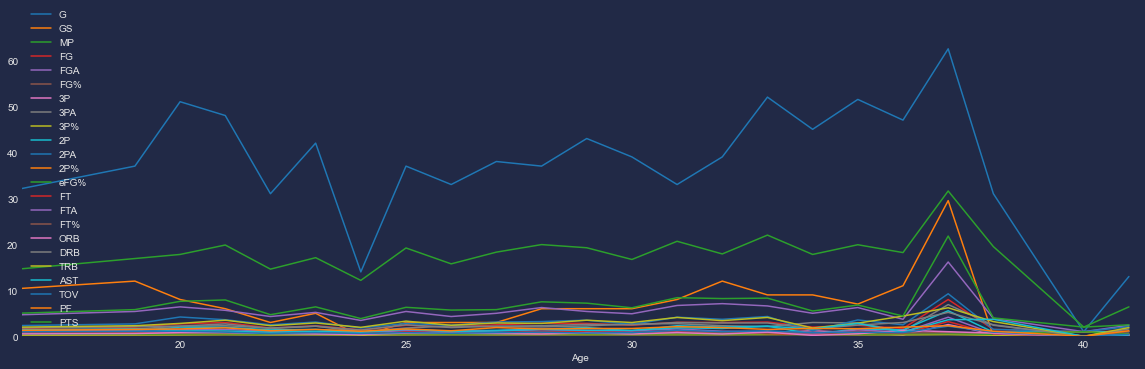

In [55]:
# does age affect players performance 

(df
 .groupby('Age') 
 [continus_numerical_features]
 .median()
 .plot(figsize= (20,5.5))
 .set(xlim=(16.5 , 41.2 ), ylim= (0.0 , 65) )
  
)

<AxesSubplot:xlabel='Pos'>

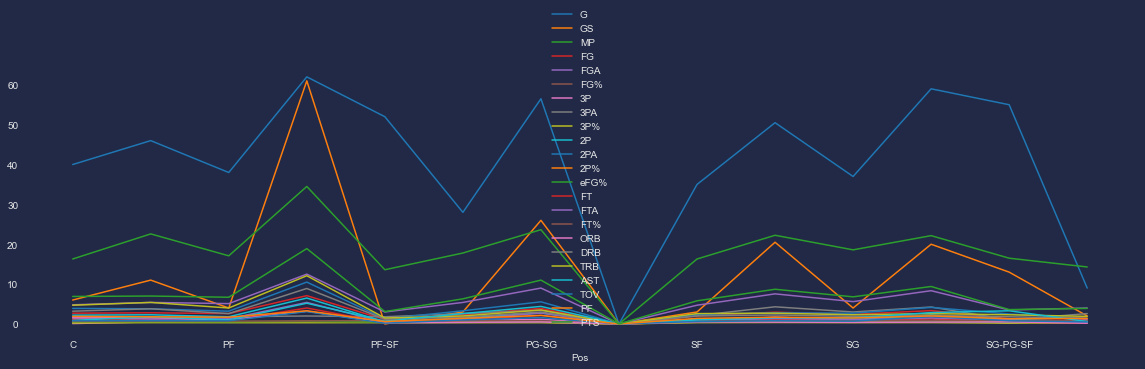

In [56]:
(df
 .groupby('Pos') 
 [continus_numerical_features]
 .median()  
 .plot(figsize=(20,5))
  
 
 


)

In [57]:
# Principal Component Analysis 
from sklearn import cluster , decomposition , preprocessing , tree


#prep the data 
x = df.drop(columns=['Player' , 'Pos' , 'Tm' , 'Rk'])
x_std = pd.DataFrame(preprocessing.StandardScaler() 
                    .fit_transform(x) , columns=x.columns)


pca = decomposition.PCA()
x_pca = pca.fit_transform(x_std)

In [59]:
pd.DataFrame(x_pca , columns = [f'PCA{n}' for n in range(x_pca.shape[1])])

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20,PCA21,PCA22,PCA23,PCA24,PCA25
0,2.102877,1.082571,1.215988,-1.585029,-0.708138,-0.204531,-0.170806,-0.069759,0.875186,-0.465864,-0.050044,0.100062,-0.184920,0.593946,0.106240,0.033012,-0.072311,0.210398,0.107901,-0.237469,0.086507,-0.024587,0.031388,-0.014624,-0.002923,0.012163
1,3.415056,3.485740,3.845935,-2.160915,0.784167,1.124674,-0.815549,-1.688783,0.814456,-0.785712,1.272163,-0.671704,0.672937,-0.935786,1.861972,0.353650,0.576235,0.156140,0.075292,-0.070886,0.136203,-0.096312,0.009804,-0.004320,0.008366,0.014903
2,7.669256,1.354481,4.866217,1.143621,0.212929,0.095076,0.521846,-0.998939,-0.110773,-0.327736,-0.186507,0.357125,0.999854,-0.017914,-0.631176,-0.404227,-0.609747,0.186593,-0.183283,-0.022897,0.006635,-0.290789,0.017391,0.022142,0.015573,0.001855
3,-1.967553,0.814929,0.565507,0.206222,-0.567226,-0.076274,0.065170,-0.240001,-0.501386,-0.505516,-0.021931,-0.217391,-0.180520,0.310527,0.095891,0.309553,0.227606,0.028004,0.142031,0.061985,0.048416,0.022623,0.005141,-0.001125,0.012287,0.001342
4,2.855899,2.202930,0.991786,0.431705,0.296234,-1.578674,-0.978646,0.083989,0.020083,0.448979,-1.736802,-0.753928,-0.389940,0.360863,-0.300359,-0.013588,0.001089,0.072225,-0.176044,0.002522,-0.167435,-0.026726,0.003008,-0.002145,0.012032,-0.012638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,0.280648,1.160456,-0.257362,-0.324396,1.607091,0.338586,0.202792,0.782990,1.057984,0.068629,-0.300821,-0.327314,0.985545,0.303225,0.082112,0.117406,0.027524,-0.133161,-0.025945,-0.097878,0.070388,0.043223,0.006368,0.000606,0.013000,-0.015526
838,9.626588,-4.814649,0.129854,3.145126,-1.403541,0.011505,-0.196606,-1.355791,0.263412,0.561821,0.950926,0.011504,-0.598456,-0.157545,1.632730,0.323934,0.422507,-0.334608,-0.109781,-0.031882,-0.250235,-0.037121,-0.008462,-0.031479,0.007970,0.002391
839,-0.416410,2.083574,1.334715,-0.245705,-0.471757,0.151209,-0.201711,-0.839461,-0.023486,-0.669752,0.079859,-0.260486,-0.155953,0.482914,-0.126275,-0.426232,-0.137241,-0.156203,0.103140,-0.108696,0.013783,-0.006978,0.009767,0.028041,0.001381,-0.000826
840,-0.590009,2.556575,1.089349,0.772356,0.620908,-0.413017,-0.204238,-0.614470,-0.689272,-1.224517,0.272300,0.425814,0.350971,-0.027587,0.573738,-0.305354,0.039860,-0.141749,-0.052059,-0.040434,-0.066225,-0.012121,-0.014742,-0.029213,-0.004949,-0.000904


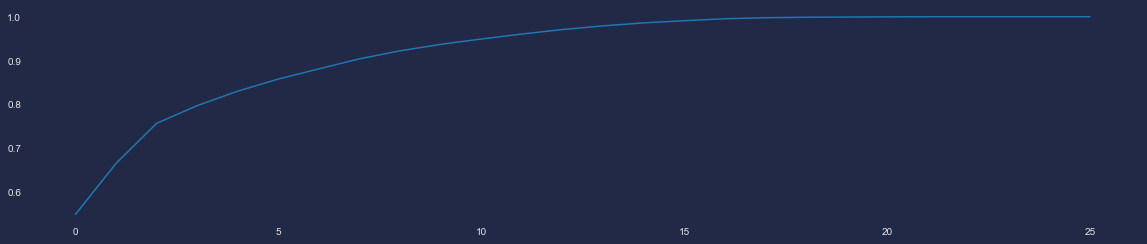

In [81]:
fig , ax = plt.subplots(figsize=(20,4))
ax.plot(np.cumsum(pca.explained_variance_ratio_))

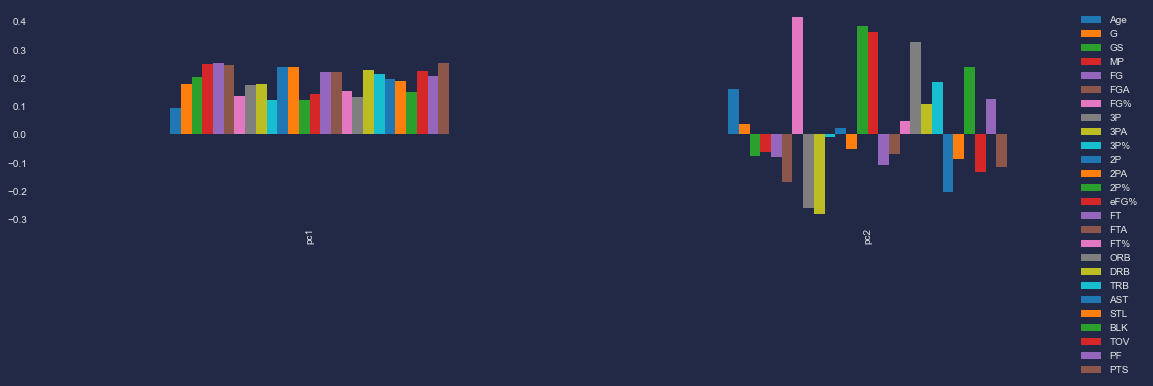

In [80]:
(pd.DataFrame(pca.components_ , columns=x_std.columns , 
     index=[f'pc{n+1}' for n in range(x_pca.shape[1])])
  .iloc[:2]
  .plot.bar(figsize=(20,4))
  .legend(bbox_to_anchor=(1,1))

)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

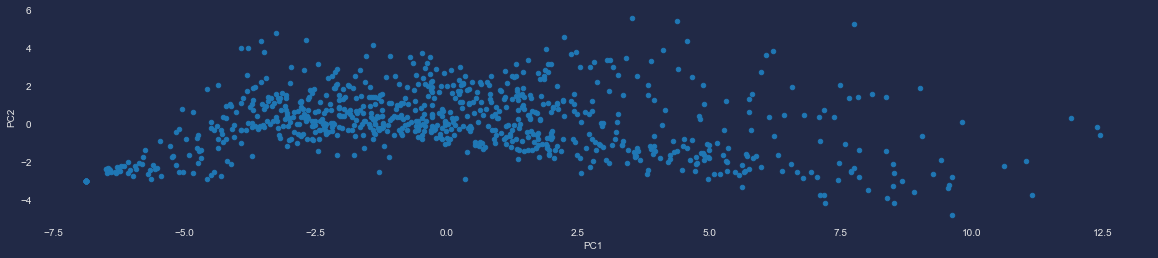

In [83]:
(pd.DataFrame(x_pca , columns = [f'PC{n+1}' for n in range(x_pca.shape[1])])
  .plot.scatter(x = 'PC1' , y = 'PC2', figsize =(20,4))
   

)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

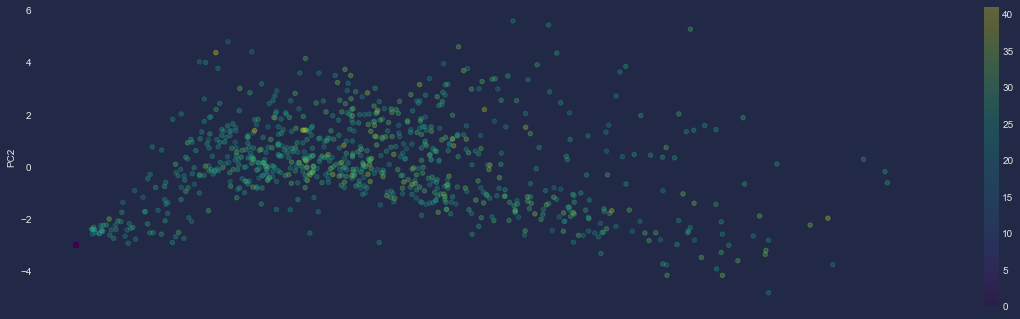

In [82]:
(pd.DataFrame(x_pca , columns = [f'PC{n+1}' for n in range(x_pca.shape[1])])
  .plot.scatter(x = 'PC1' , y = 'PC2' , 
    c=df.Age, cmap = 'viridis', alpha = .3,figsize =(20,5.5) )
  

)